## **Lectura de datos**

In [60]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from mlxtend.preprocessing import TransactionEncoder
from ipywidgets import interact
from sklearn import neighbors
import os
os.getcwd()


'/content'

In [62]:
!git clone "https://github.com/AngelicaCeDi/Analitica-3-Caso-Marketing.git"

fatal: destination path 'Analitica-3-Caso-Marketing' already exists and is not an empty directory.


In [63]:
os.chdir('/content')

In [64]:
conn= sql.connect("/content/Analitica-3-Caso-Marketing/db_movies")
cur=conn.cursor()

In [65]:
#Creamos una copia de los datos originales de db_movies.
#conn=sql.connect('db_movies') # crear cuando no existe el nombre de cd  y para conectarse cuando sí existe.
#cur=conn.cursor() #para funciones que ejecutan sql en base de datos

In [66]:
#Exploramos que tablas que hay en el sql. 
cur.execute("SELECT name FROM sqlite_master where type='table' ")
cur.fetchall()

[('ratings',),
 ('movies',),
 ('recomendationsUser',),
 ('df_rt',),
 ('df_mov',),
 ('mov_data',)]

In [67]:
# Las tablas las llevamos a python.
movies = pd.read_sql("SELECT* FROM movies", conn)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [68]:
ratings = pd.read_sql("SELECT* FROM ratings", conn)
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## **Limpieza y transformación**

In [69]:
#Se hace una copia de la tablas originales. 
df_mov=movies.copy()
df_rt=ratings.copy()

In [70]:
#Vemos el tamaño de las tablas.
print(df_mov.shape)
print('----------------')
print(df_rt.shape)

(9742, 3)
----------------
(100836, 4)


In [71]:
#Tipos de variable de cada columna.
print(df_mov.dtypes)
print('----------------')
print(df_rt.dtypes)

movieId     int64
title      object
genres     object
dtype: object
----------------
userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


In [72]:
#Vemos si las tablas tienen valores nulos. 
print(df_mov.isnull().sum())
print('----------------')
print(df_rt.isnull().sum()) 

movieId    0
title      0
genres     0
dtype: int64
----------------
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [73]:
#Vemos si las tablas tienen datos duplicados
print(df_mov.duplicated().sum())
print('----------------')
print(df_rt.duplicated().sum()) 

0
----------------
0


In [74]:
#En el dataframe df_rt se cambia el formato de timestamp por uno de fecha para hacer su manejo mas cómodo. 
df_rt['time'] =pd.to_datetime(df_rt['timestamp'], unit='s')
df_rt.drop(columns=["timestamp"],inplace=True)
df_rt.head()

,userId,movieId,rating,time
0,1,1,4.0,2000-07-30 18:45:03
1,1,3,4.0,2000-07-30 18:20:47
2,1,6,4.0,2000-07-30 18:37:04
3,1,47,5.0,2000-07-30 19:03:35
4,1,50,5.0,2000-07-30 18:48:51


In [75]:
# Se separan los generos para mejor manejo del dataframe 
genres=df_mov['genres'].str.split('|')
transactionencoder= TransactionEncoder()
genres = transactionencoder.fit_transform(genres)
genres = pd.DataFrame(genres, columns = transactionencoder.columns_)
genres  = genres.astype(int)
df_mov = movies.drop(['genres'], axis = 1) 
df_mov =pd.concat([df_mov, genres],axis=1)
df_mov

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
#Obtenemos el año de premiere de cada pelicula de su titulo.
df_mov['movyear'] = df_mov['title'].str[-5:-1]

In [77]:
#Se ve un año que no corresponde a un número, se decide eliminar este registro.
df_mov['movyear'].unique()

array(['1995', '1994', '1996', '1976', '1992', '1967', '1993', '1964',
       '1977', '1965', '1982', '1990', '1991', '1989', '1937', '1940',
       '1969', '1981', '1973', '1970', '1955', '1959', '1968', '1988',
       '1997', '1972', '1943', '1952', '1951', '1957', '1961', '1958',
       '1954', '1934', '1944', '1960', '1963', '1942', '1941', '1953',
       '1939', '1950', '1946', '1945', '1938', '1947', '1935', '1936',
       '1956', '1949', '1932', '1975', '1974', '1971', '1979', '1987',
       '1986', '1980', '1978', '1985', '1966', '1962', '1983', '1984',
       '1948', '1933', '1931', '1922', '1998', '1929', '1930', '1927',
       '1928', '1999', '2000', '1926', '1919', '1921', '1925', '1923',
       '2001', '2002', '2003', '1920', '1915', '1924', '2004', '1916',
       '1917', '999)', '2005', '2006', '1902', 'lon ', '1903', '2007',
       '2008', '008)', '007)', '2009', '2010', '2011', '2012', '011)',
       '998)', '995)', '2013', '012)', '973)', '2014', '2015', '014)',
      

In [78]:
df_mov=df_mov[df_mov["movyear"].str.contains ('r On') == False ]

In [79]:
df_mov['movyear'].unique()

array(['1995', '1994', '1996', '1976', '1992', '1967', '1993', '1964',
       '1977', '1965', '1982', '1990', '1991', '1989', '1937', '1940',
       '1969', '1981', '1973', '1970', '1955', '1959', '1968', '1988',
       '1997', '1972', '1943', '1952', '1951', '1957', '1961', '1958',
       '1954', '1934', '1944', '1960', '1963', '1942', '1941', '1953',
       '1939', '1950', '1946', '1945', '1938', '1947', '1935', '1936',
       '1956', '1949', '1932', '1975', '1974', '1971', '1979', '1987',
       '1986', '1980', '1978', '1985', '1966', '1962', '1983', '1984',
       '1948', '1933', '1931', '1922', '1998', '1929', '1930', '1927',
       '1928', '1999', '2000', '1926', '1919', '1921', '1925', '1923',
       '2001', '2002', '2003', '1920', '1915', '1924', '2004', '1916',
       '1917', '999)', '2005', '2006', '1902', 'lon ', '1903', '2007',
       '2008', '008)', '007)', '2009', '2010', '2011', '2012', '011)',
       '998)', '995)', '2013', '012)', '973)', '2014', '2015', '014)',
      

In [80]:
#Se crea una tabla en general para trabajar los modelos que necesiten datos cruzados.
mov_data=pd.merge(df_mov,df_rt, on='movieId')
mov_data

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,movyear,userId,rating,time
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,1995,1,4.0,2000-07-30 18:45:03
1,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,1995,5,4.0,1996-11-08 06:36:02
2,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,1995,7,4.5,2005-01-25 06:52:26
3,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,1995,15,2.5,2017-11-13 12:59:30
4,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,1995,17,4.5,2011-05-18 05:28:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100827,193581,Black Butler: Book of the Atlantic (2017),0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,2017,184,4.0,2018-09-16 14:44:42
100828,193583,No Game No Life: Zero (2017),0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,2017,184,3.5,2018-09-16 14:52:25
100829,193585,Flint (2017),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2017,184,3.5,2018-09-16 14:56:45
100830,193587,Bungo Stray Dogs: Dead Apple (2018),0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,2018,184,3.5,2018-09-16 15:00:21


In [81]:
#Cantidad de calificaciones que tiene cada usuario.
numusers=pd.DataFrame(df_rt.groupby(('userId'))['rating'].count().sort_values(ascending=False))
numusers

,rating
userId,
414,2698
599,2478
474,2108
448,1864
274,1346
...,...
442,20
569,20
320,20


In [82]:
fig=px.histogram(numusers, x='rating', title='Histograma usuarios')
fig.show() #La mayoría de usuarios calificaron muy pocas peliculas y solo uno calificó 2698 peliculas lo que podrian considerar datos atipicos sesgando las recomendaciones.

In [83]:
#Cantidad de calificaciones por pelicula  
nummov=pd.DataFrame(df_rt.groupby(('movieId'))['rating'].count().sort_values(ascending=False))
nummov

,rating
movieId,
356,329
318,317
296,307
593,279
2571,278
...,...
4093,1
4089,1
58351,1


In [84]:
#Cantidad de calificaciones que tiene cada pelicula.
fig=px.histogram(nummov, x='rating', title='Histograma movies')
fig.show() # Muchas peliculas tienen muy pocas calificaciones que podrian sesgar las recomendaciones. 

In [85]:
#Debido a lo anterior, se requiere que las tablas generadas tengas datos que no sesgen los modelos, en este caso se limitaran a los uruarios que tienen menos de 1500 peliculas calificadas y 
#las peliculas que tienen mas de 3 calificaciones.
newuser = numusers.drop(numusers[numusers['rating']>1500].index).reset_index()
newmovs = nummov.drop(nummov[nummov['rating']<3].index).reset_index()


In [86]:
#Hacemos una tabla para actualizar la información el Id de los usuarios que tienen menos de 1500 peiculas calificadas.
dicuser= newuser.drop(columns=['rating'])
dicuser.dtypes

userId    int64
dtype: object

In [87]:
#Hacemos una tabla para actualizar la información el Id de las peliculas que tienen mas de 3 calificaciones.
dicmov= newmovs.drop(columns=['rating'])
dicmov.dtypes

movieId    int64
dtype: object

In [88]:
#Realizamos un merge para tener la nueva indormación en las tablas, peliculas con mas de 3 calificaciones y usuarios que han calificado menos de 1500 peliculas.
mov_data=pd.merge(mov_data,dicmov,how='inner', on='movieId')
df_mov=pd.merge(df_mov,dicmov,how='inner', on='movieId')
df_rt=pd.merge(df_rt,dicuser,how='inner',on='userId')

In [89]:
#Verificamos duplicados o nulos, ya que al unir tablas aveces se presentan estos imperfectos.
print(mov_data.isnull().sum())
print('----------------')
print(mov_data.duplicated().sum()) #Observamos que ninguna de las tablas presentadas tiene presencia de nulos, registros extraños o registros duplicados.
print('----------------')
print(df_mov.isnull().sum())
print('----------------')
print(df_mov.duplicated().sum())
print('----------------')
print(df_rt.isnull().sum())
print('----------------')
print(df_rt.duplicated().sum())

movieId               0
title                 0
(no genres listed)    0
Action                0
Adventure             0
Animation             0
Children              0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror                0
IMAX                  0
Musical               0
Mystery               0
Romance               0
Sci-Fi                0
Thriller              0
War                   0
Western               0
movyear               0
userId                0
rating                0
time                  0
dtype: int64
----------------
0
----------------
movieId               0
title                 0
(no genres listed)    0
Action                0
Adventure             0
Animation             0
Children              0
Comedy                0
Crime                 0
Documentary           0
Drama                 0
Fantasy               0
Film-Noir             0
Horror         

In [90]:
#Se guardan las 3 tablas generadas en la base de datos de SQL.
df_rt.to_sql("df_rt", conn, if_exists="replace")
df_mov.to_sql("df_mov", conn, if_exists="replace")
mov_data.to_sql("mov_data", conn, if_exists="replace")

94790

In [91]:
#Se confirma que si se hayan guardado las tablas correctamente.
cur.execute("SELECT name FROM sqlite_master where type='table' ")
cur.fetchall()

[('ratings',),
 ('movies',),
 ('recomendationsUser',),
 ('df_rt',),
 ('df_mov',),
 ('mov_data',)]

In [92]:
#Cantidad de peliculas. 
pd.read_sql("""select count(title) as cantidad_registros_movies from movies""", conn) 

,cantidad_registros_movies
0,9742


In [93]:
#Cantidad de registros.
pd.read_sql("""select count(userId) as cantidad_registros_ratings from ratings""", conn)

,cantidad_registros_ratings
0,100836


In [94]:
# Número de peliculas por géneros.
pd.read_sql("""select movieId, genres, count(title) from movies group by genres order by count(title) desc """, conn)

,movieId,genres,count(title)
0,14,Drama,1053
1,5,Comedy,946
2,72,Comedy|Drama,435
3,3,Comedy|Romance,363
4,17,Drama|Romance,349
...,...,...,...
946,3745,Action|Adventure|Animation|Children|Sci-Fi,1
947,558,Action|Adventure|Animation|Children|Fantasy,1
948,84944,Action|Adventure|Animation|Children|Comedy|Wes...,1
949,85261,Action|Adventure|Animation|Children|Comedy|Sci...,1


In [95]:
#Número de usuarios que calificaron títulos.
pd.read_sql("""select count(distinct(userId)) as cantidad_usuarios from ratings""", conn)

,cantidad_usuarios
0,610


In [96]:
#Numero de titulos por género (hay titulos que comparten generos).
pd.DataFrame(df_mov.loc[:,~df_mov.columns.isin(['title','movieId','movyear'])].sum().sort_values(ascending=False))
#La mayoria de las peliculas son del género de Drama seguidas de las de comedia, esto es debido a que los primeros generos del cine 
#fueron la tragedia y la comedia por lo tanto hay muchas mas peliculas producidas de estos géneros.

,0
Drama,2206
Comedy,2012
Action,1148
Thriller,1137
Romance,891
Adventure,814
Crime,693
Sci-Fi,600
Fantasy,455
Horror,441


In [97]:
#Top 10 peliculas más calificadas.
mt= pd.read_sql('''select title, count(*) as conteo from mov_data group by title order by conteo desc limit 10''', conn)

dfmt  = go.Bar( x=mt.title,y=mt.conteo, text=mt.conteo, textposition="outside")
Layout=go.Layout(title="<b>Top 10 movies<b>",xaxis={'title':'title'},yaxis={'title':'# Ratings'})
go.Figure(dfmt,Layout)

#Las peliculas que mas fueron calificadas independiente de si tuvo buenas o malas calificaciones fueron Forrest Gump (1994), Shawnshank Redemption(1994) y Pulp Fiction (1994), 
#llama la atención que todas las peliculas tienen el mismo año de premiere y en la epoca de los años 90s.

In [98]:
# Número de lanzamientos por año.
base = mov_data.groupby(['movyear'])[['movieId']].count().sort_values('movyear', ascending= True).reset_index()

base  = go.Bar( x=base.movyear, y= base.movieId, textposition="outside")
Layout=go.Layout(title="<b>Premieres per year<b>",xaxis={'title':'year'},yaxis={'title':'count'})
go.Figure(base,Layout)

#Como s epuede evidenciar en el gráfico, el año con más número de lanzamientos es 1995 seguido de 1994 y 1999. 
#Esto tiene sentido pues la decada de los 90s fue en donde se presento la mayor producción de cine del mundo pues 
#nacieron muchos directores por esta epoca y se probaron muchisimos estilos y metodos en las peliculas ya que iba de la mano con la tecnología que surgía en esos años.

In [99]:
base2= pd.read_sql('''select rating,count(*) as conteo from mov_data group by rating order by conteo desc''', conn)

base2  = go.Bar( x=base2.rating, y= base2.conteo, textposition="outside")
Layout=go.Layout(title="<b>Favorite Rating<b>",xaxis={'title':'rating'},yaxis={'title':'count'})
go.Figure(base2,Layout)

#La calificación que más se colocó en los ratings es el 4 seguido de un 3 y un 5, 
#esto quiere decir que los usuarios en general se han sentido satisfechos con las peliculas que ofrece la plataforma online.  

## **Modelos**

### **Modelo de recomendación basado en Popularidad**
  Criterios:

  1-Peliculas con mayor rating.

  2-Número de vistas.

Se realiza un conteo de las calificaciones y se clasifican como número de vistas (views), tambien se calcula el promedio del rating por pelicula y se agrupa en un solo dataframe.

In [101]:
rtmc=pd.read_sql('''select title,avg(rating) as rating, count(rating) as views from mov_data group by title''', conn)
rtmc

,title,rating,views
0,"'burbs, The (1989)",3.176471,17
1,(500) Days of Summer (2009),3.666667,42
2,*batteries not included (1987),3.285714,7
3,...And Justice for All (1979),3.166667,3
4,10 (1979),3.375000,4
...,...,...,...
4974,[REC]² (2009),3.666667,3
4975,eXistenZ (1999),3.863636,22
4976,xXx (2002),2.770833,24
4977,xXx: State of the Union (2005),2.000000,5


In [102]:
#Redondeamos el rating
rtmc['rating']=round(rtmc['rating'],1)

In [103]:
#Filtramos la tabla solo para quedarnos con los titulos con un rating mayor a 4 y mas de 150 puntuaciones.
rtmc=rtmc[(rtmc['rating'] > 4) & (rtmc['views'] > 150)]
rtmc

,title,rating,views
208,American Beauty (1999),4.1,204
1497,Fargo (1996),4.1,181
1536,Fight Club (1999),4.3,218
1622,Forrest Gump (1994),4.2,329
1782,"Godfather, The (1972)",4.3,192
2659,"Lord of the Rings: The Fellowship of the Ring,...",4.1,198
2660,"Lord of the Rings: The Return of the King, The...",4.1,185
2819,"Matrix, The (1999)",4.2,278
2857,Memento (2000),4.1,159
3554,Pulp Fiction (1994),4.2,307


In [104]:
#Ordenamos la tabla de modo que se obeserven los 10 titulos de mejor puntuación y mas de 150 views.
rtmc=rtmc.sort_values(by='rating', ascending=False)
rtmc.head(10)

,title,rating,views
3941,"Shawshank Redemption, The (1994)",4.4,317
1536,Fight Club (1999),4.3,218
1782,"Godfather, The (1972)",4.3,192
3554,Pulp Fiction (1994),4.2,307
3592,Raiders of the Lost Ark (Indiana Jones and the...,4.2,200
4168,Star Wars: Episode V - The Empire Strikes Back...,4.2,211
4167,Star Wars: Episode IV - A New Hope (1977),4.2,251
3982,"Silence of the Lambs, The (1991)",4.2,279
3846,Schindler's List (1993),4.2,220
4678,"Usual Suspects, The (1995)",4.2,204


##### 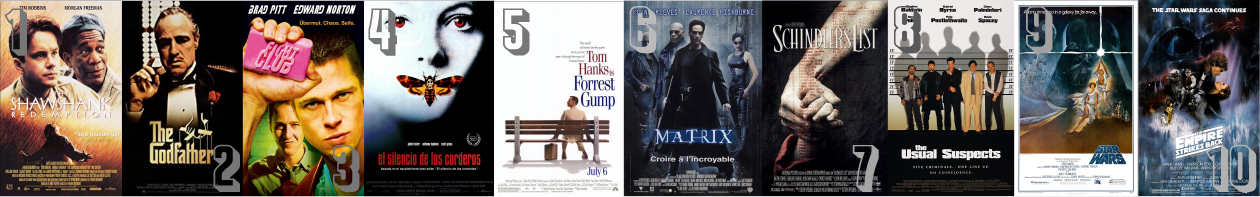

In [105]:
#Grafico de popularidad

# crear gráfica
fig = px.bar(rtmc, x = rtmc.title , y='views', color = 'rating', 
             title= '<b>Top 10 Pupular Movies<b>',
              color_continuous_scale='balance')

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Movie',
    yaxis_title = 'Views',
    template = 'simple_white',
    title_x = 0.5)

fig.show()

### **Modelos de recomendación basados en Contenido**


#### **Recomendaciones basandose en una pelicula vista por el usuario**

In [106]:
#Tabla con los datos que necesitamos.
df_mov2=pd.read_sql('''select* from df_mov''', conn)


In [107]:
#Escalamos el año de premiere.
sc=MinMaxScaler()
df_mov2[["year"]]=sc.fit_transform(df_mov2[['movyear']])

In [108]:
#Eliminamos las columnas que no necesitamos para el modelo de los datos como movieId.
df_mov2= df_mov2.drop(columns=['index','movieId','movyear'])
df_mov2.head()

,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,Toy Story (1995),0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.801724
1,Jumanji (1995),0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.801724
2,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0.801724
3,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0.801724
4,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0.801724


In [109]:
#Volvemos la columna title dummies
dummov=pd.get_dummies(df_mov2,columns=['title'])
dummov.head(3)

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,title_Zoolander (2001),title_Zoolander 2 (2016),title_Zootopia (2016),title_Zulu (1964),title_[REC] (2007),title_[REC]² (2009),title_eXistenZ (1999),title_xXx (2002),title_xXx: State of the Union (2005),title_¡Three Amigos! (1986)
0,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
#Entrenamos el modelo Naires Neighbors
model = neighbors.NearestNeighbors(n_neighbors=15, metric='cosine')
model.fit(dummov)
dist, idlist = model.kneighbors(dummov)
#Se crea las tablas con las distancias entre los titulos y las correlaciones
distancias=pd.DataFrame(dist)
id_list=pd.DataFrame(idlist)

In [111]:
#Generamos las recomendaciones de acuerdo al titulo siendo recomendaciones de peliculas relacionadas con el titulo propuesto
mov_name='Toy Story (1995)'

def MovRecommender(mov_name = list(df_mov['title'].value_counts().index)):
    mov_list_name = []
    mov_id = df_mov[df_mov['title'] == mov_name].index
    mov_id = mov_id[0]
    for newid in idlist[mov_id]:
        mov_list_name.append(df_mov.loc[newid].title)
    return mov_list_name



print(interact(MovRecommender))

interactive(children=(Dropdown(description='mov_name', options=('Toy Story (1995)', '3 Women (Three Women) (19…

<function MovRecommender at 0x7f56144d1700>


#### **Recomendaciones de acuerdo a todas las peliculas consumidas por el usuario**


In [112]:
#Usamos la tabla de datos final con los titulos los raitings, generos y información del usuario
df_cmov=pd.read_sql('''select* from mov_data''', conn)

In [113]:
#Eliminamos columnas que no usaremos para el modelo basado en contenido
df_cmov=mov_data.drop(columns=['time','movieId','movyear'])
df_cmov

,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,userId,rating
0,Toy Story (1995),0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,4.0
1,Toy Story (1995),0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,5,4.0
2,Toy Story (1995),0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,7,4.5
3,Toy Story (1995),0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,15,2.5
4,Toy Story (1995),0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,17,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94785,Solo: A Star Wars Story (2018),0,1,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,514,3.0
94786,Solo: A Star Wars Story (2018),0,1,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,586,5.0
94787,Ant-Man and the Wasp (2018),0,1,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,50,3.0
94788,Ant-Man and the Wasp (2018),0,1,1,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,380,4.0


In [114]:
# volvemos el title dummies
df_cmov2=pd.get_dummies(df_cmov,columns=['title'])
users=pd.read_sql('select distinct (userId) as userId from ratings',conn)

In [115]:
df_cmov2.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,title_Zoolander (2001),title_Zoolander 2 (2016),title_Zootopia (2016),title_Zulu (1964),title_[REC] (2007),title_[REC]² (2009),title_eXistenZ (1999),title_xXx (2002),title_xXx: State of the Union (2005),title_¡Three Amigos! (1986)
0,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [116]:

User=411
def UsRecommender(User=list(users['userId'].value_counts().index)):
    
    ###seleccionar solo los ratings del usuario seleccionado
    ratingus=pd.read_sql('select *from ratings where userId=:User',conn, params={'User':User})
    ###convertir ratings del usuario a array
    mov_r=ratingus['movieId'].to_numpy()
    
    ###agregar la columna de isbn y titulo del libro a dummie para filtrar y mostrar nombre
    df_cmov2[['movieId']]=mov_data[['movieId']]
    movie_r=df_cmov2[df_cmov2['movieId'].isin(mov_r)]
    movie_r=movie_r.drop(columns=['movieId'])
    movie_r["indice"]=1 ### para usar group by y que quede en formato pandas tabla de centroide
    centroide=movie_r.groupby("indice").mean()
    
    
    movie_nr=df_cmov2[~df_cmov2['movieId'].isin(mov_r)]
    movie_nr=movie_nr.drop(columns=['movieId'])
    model=neighbors.NearestNeighbors(n_neighbors=20, metric='cosine')
    model.fit(movie_nr)
    dist, idlist = model.kneighbors(centroide)
    
    ids=idlist[0]
    recomend_m=mov_data.loc[ids][['title','movieId']]
    leidos=mov_data[mov_data['movieId'].isin(mov_r)][['title','movieId']]
    
    return recomend_m


UsRecommender(411)


print(interact(UsRecommender))

interactive(children=(Dropdown(description='User', options=(1, 410, 403, 404, 405, 406, 407, 408, 409, 411, 45…

<function UsRecommender at 0x7f5614a768b0>


In [117]:
#Celda para analizar si el modelo esta recomendando peliculas coherentes a los gustos del usuario.
in_1 = mov_data['userId'] == 411
usuaru1= mov_data[in_1]

In [118]:
usuaru1

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,movyear,userId,rating,time
144,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,1995,411,5.0,1996-06-23 12:15:55
280,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1995,411,4.0,1996-06-23 12:19:58
382,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1995,411,2.0,1996-06-23 12:30:21
570,7,Sabrina (1995),0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1995,411,3.0,1996-06-23 12:37:51
698,10,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,1995,411,3.0,1996-06-23 12:14:25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16273,593,"Silence of the Lambs, The (1991)",0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1991,411,5.0,1996-06-23 12:15:00
16736,597,Pretty Woman (1990),0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,1990,411,3.0,1996-06-23 12:23:34
17352,648,Mission: Impossible (1996),0,1,1,0,0,0,0,0,...,1,0,0,1,0,0,1996,411,5.0,1996-06-23 12:29:54
17514,661,James and the Giant Peach (1996),0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,1996,411,2.0,1996-06-23 12:36:44


### **Modelo de recomendación basado en filtros colaborativos**

In [119]:
#Importación de paquetes importantes
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise.model_selection import train_test_split

In [120]:
mov_data['rating'].unique()

array([4. , 4.5, 2.5, 3.5, 3. , 5. , 0.5, 2. , 1.5, 1. ])

#### **Sistema de recomendación filtro colaborativo basado en el usuario**

In [121]:
#Creación del dataframe con su orden correspondiente para este modelo.
df_fcut=pd.read_sql('select userId, movieId, rating from ratings',conn)
pd.read_sql('select avg(rating) from ratings', conn)
#Definición del rango de calificación
reader= Reader(rating_scale=(1, 5))

#Datos finales
df_fcu = Dataset.load_from_df(df_fcut[['userId','movieId','rating']], reader)
df_fcu

In [122]:
#Lista de modelos considerados para su selección y a lista donde seran contenidos los resultados.
modelsUs=[KNNBasic(),KNNWithMeans(),KNNWithZScore(),KNNBaseline()] 
results = {}

In [123]:
#Se realiza un ciclo for para correr los modelos y sus métricas.
for model in modelsUs:
 
    CV_scores = cross_validate(model, df_fcu, measures=["MAE","RMSE"], cv=6, n_jobs=-1)  
    result = pd.DataFrame.from_dict(CV_scores).mean(axis=0).\
             rename({'test_mae':'MAE', 'test_rmse': 'RMSE'})
    results[str(model).split("algorithms.")[1].split("object ")[0]] = result


performance_df = pd.DataFrame.from_dict(results).T
performance_df.sort_values(by='RMSE')



,MAE,RMSE,fit_time,test_time
knns.KNNBaseline,0.666348,0.871267,0.425326,2.811664
knns.KNNWithZScore,0.677478,0.892881,0.432651,2.315873
knns.KNNWithMeans,0.683439,0.894155,0.212848,2.073373
knns.KNNBasic,0.724840,0.945584,0.214475,2.338454


Se decide escoger el modelo KNNBasic por tener buenos tiempos de ejecución y entrenamiento, esto es importante pues le ahorra a la plataforma costos asociados a capacidad computacional y optimiza mucho más la plataforma online.

In [ ]:
# Se decide optar por el modelo KNN Basic tiempos mas cortos y buen RMSE

#Afinamiento de hiperparámetros.
param_grid = { 'sim_options' : {'name': ['msd','cosine', 'pearson'],   
                                'min_support': [5,7,10],   
                                'user_based': [False,True]} 
             }

gridsearchKNNBasic = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], 
                                      cv=2, n_jobs=2)
                                    
gridsearchKNNBasic.fit(df_fcu)


print(gridsearchKNNBasic.best_params["rmse"])
print(gridsearchKNNBasic.best_score["rmse"])
fcu_model=gridsearchKNNBasic.best_estimator['rmse'] # Mejor estimador de gridsearch.

"""Para el afinamiento de hiperparámetros se decide utilizar los siguientes:
Msd: calcula la similitud de la diferencia cuadrática media entre todos los pares de usuarios.
cosine: calcula la similitud del coseno entre todos los pares de usuarios.
pearson: calcula el coeficiente de correlación de Pearson entre todos los pares de usuarios.
min_support:Número mínimo de elementos comúnes para hacer la predicción.
user_based:Similitudes, cuando es basado en los usuarios se utiliza 'User_based'=True y cuando es basado en item 'User_based'=False."""

In [ ]:
#Se realizan las predicciones

trainset = df_fcu.build_full_trainset() #Convierte todos los datos en entrenamiento.
modelUser=fcu_model.fit(trainset)

predset = trainset.build_anti_testset() # Crea una tabla con todos los usuarios y las peliculas que no han visto los mismos.


predictions = modelUser.test(predset) #Función muy pesada, hace las predicciones de rating para todas las peliculas que no ha visto un usuario.
#La función test recibe un test set construido con build_test method, o el que genera crosvalidate.

predictions_df = pd.DataFrame(predictions) # Se hace una tabla para introducirla a la base de datos con todas las predicciones.

def recomendUs(user_id,n_recomend=15):
    
    predictions_userId = predictions_df[predictions_df['uid'] == user_id].sort_values(by="est", ascending = False).head(n_recomend)

    recommended = predictions_userId[['iid','est']]
    recommended.to_sql('recomendationsUser',conn,if_exists="replace")
    recommended
    recommended=pd.read_sql('''select a.*, b.title 
                             from recomendationsUser a left join movies b
                             on a.iid=b.movieId ''', conn)

    return(recommended)


Ruser=recomendUs(user_id=1,n_recomend=20)
Ruser=Ruser.drop_duplicates() 
Ruser

